<a href="https://colab.research.google.com/github/benhandy/workflow/blob/main/Augmented_NBA_Database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Augmenting an NBA Player Database for Downstream Machine Learning Development__

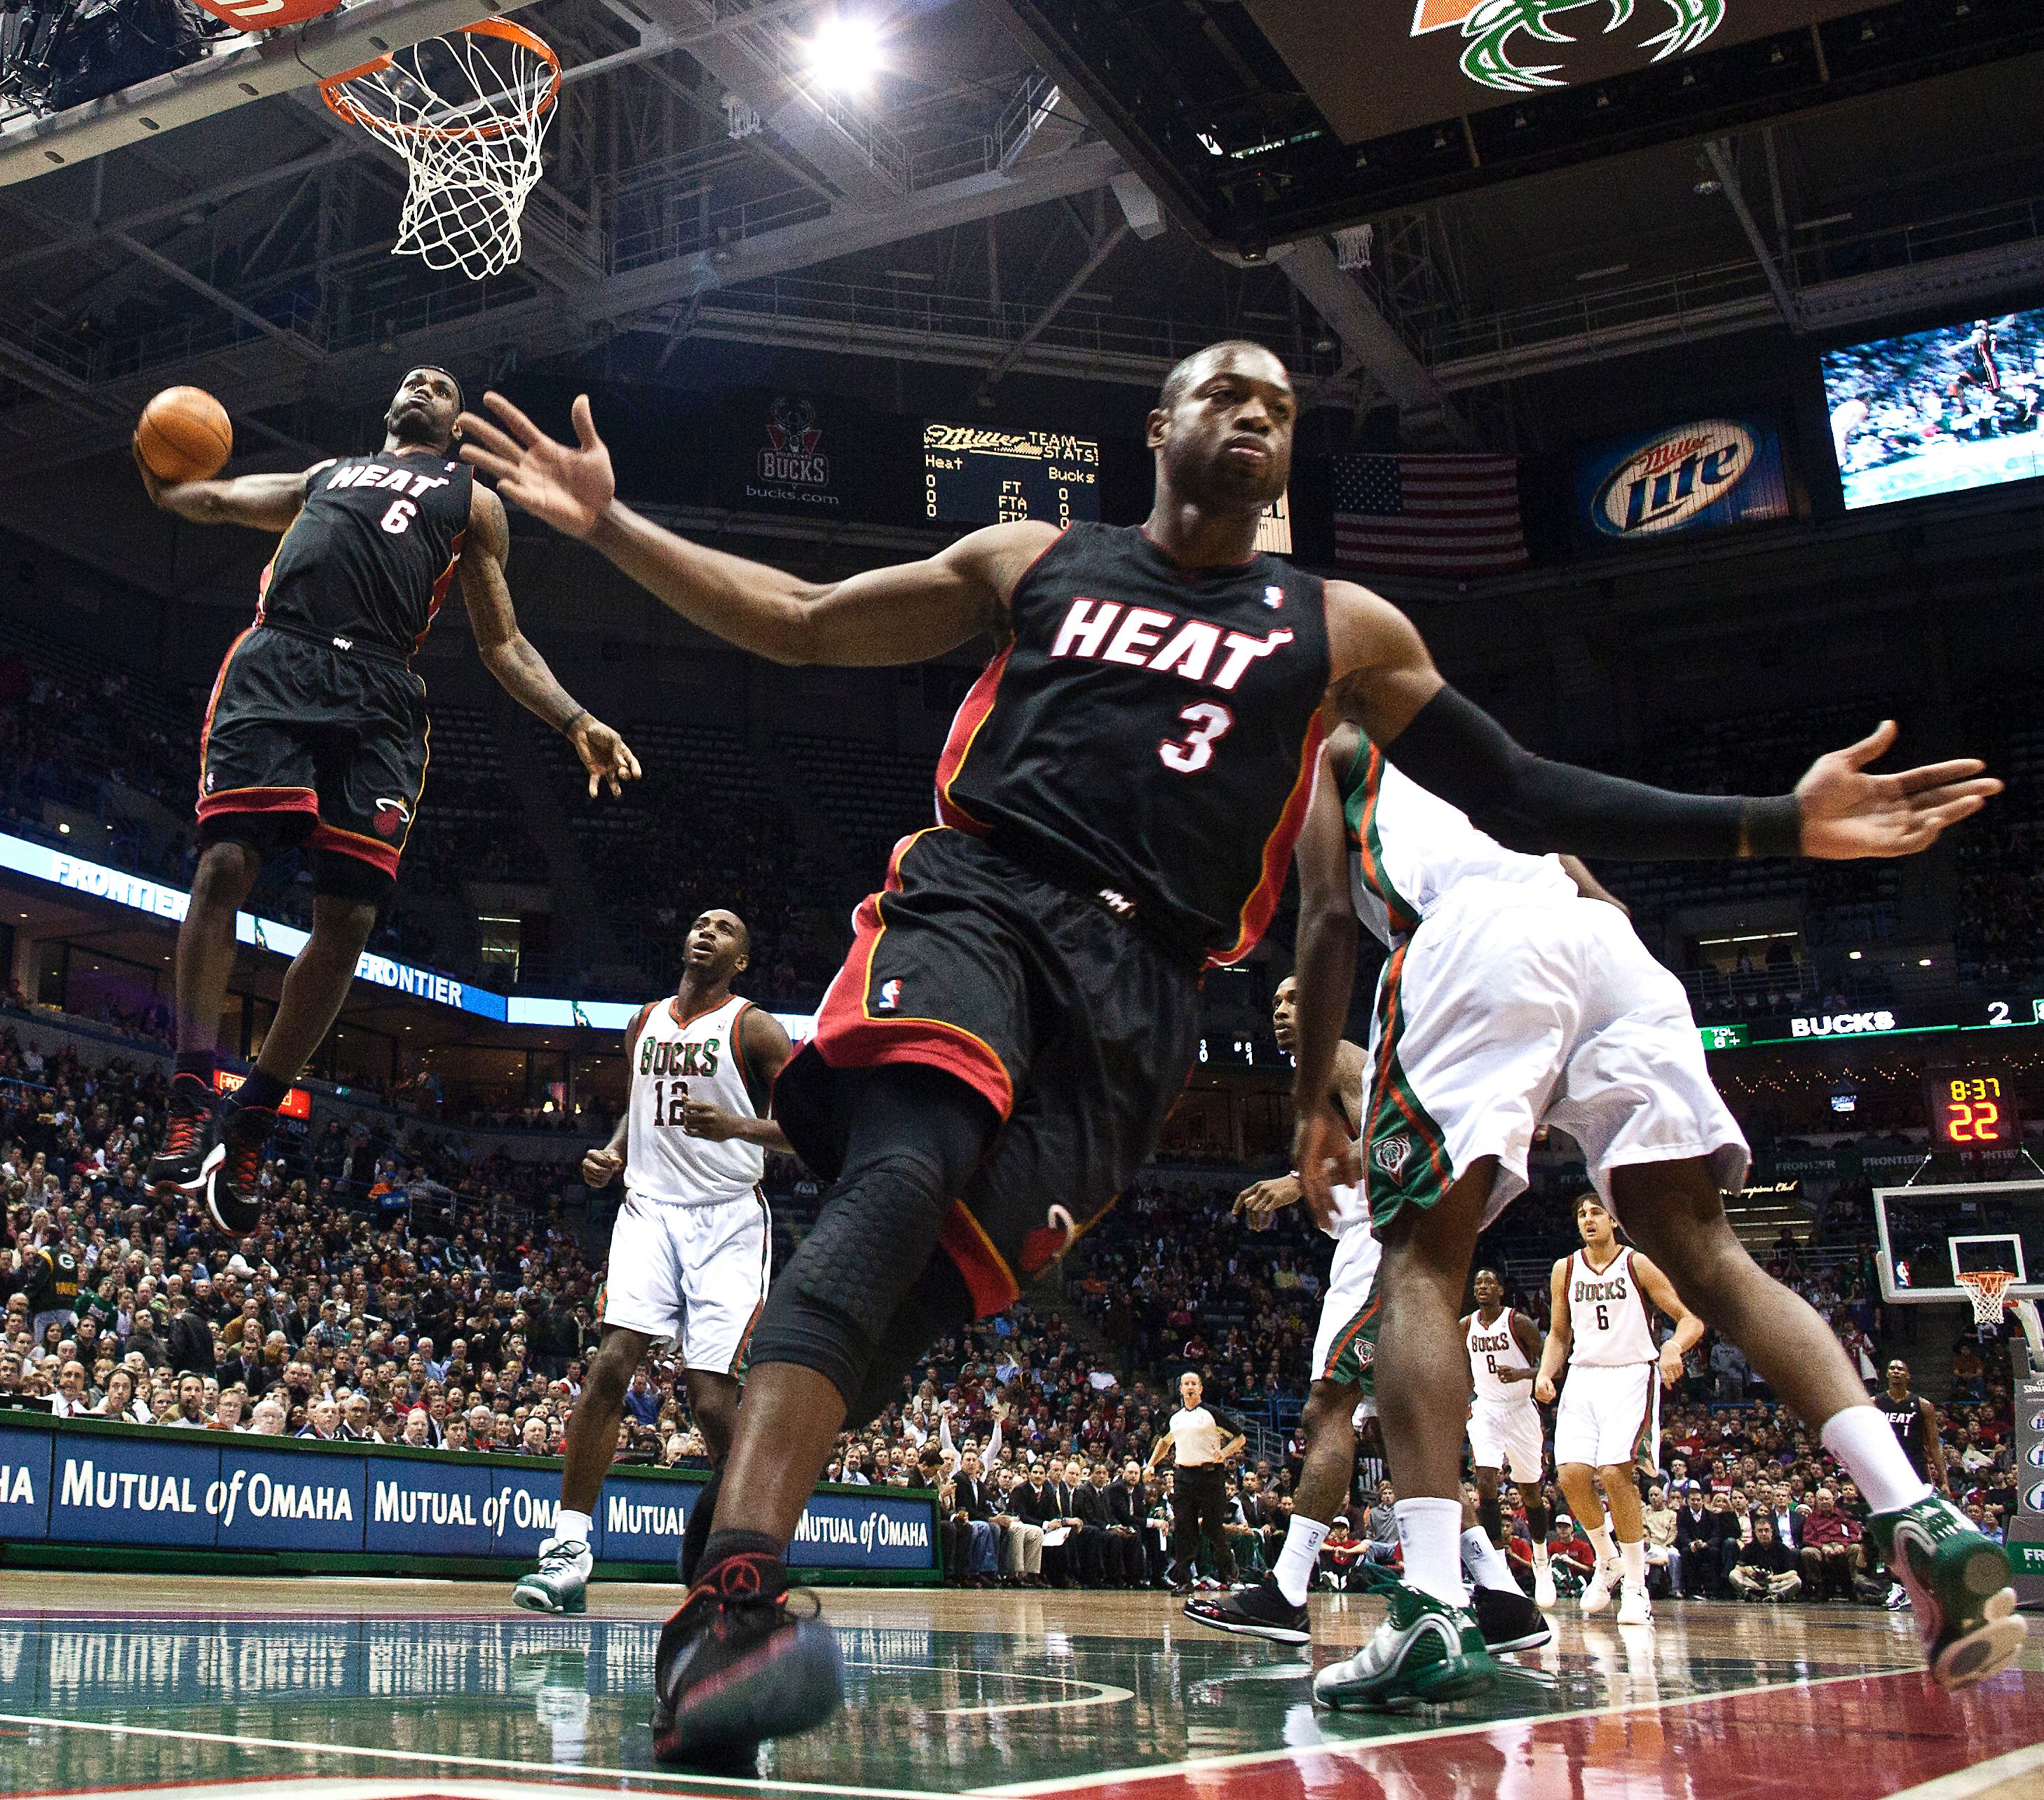
I explore the creation, manipulation, and analysis of basketball player performance data using a SQLite in-memory database, Python libraries, and visualization tools. Furthermore, this includes:


__Database Setup:__ Initializes an SQLite database to store player statistics, including points, assists, and rebounds, alongside player and team names.


__Data Ingestion:__ I insert realistic player data across multiple batches, simulating NBA player performances. This data is purposefully obsolete, as this particualar project focuses on generating large numbers of rows for practice analysis as well as reinforcing data modeling best practices


__Analysis and Insights:__
Retrieves top-performing players and calculates custom metrics like efficiency.
Identifies players with exceptional achievements, such as triple-doubles.
Computes team-level averages for performance metrics.


__Emphasizing Scalability:__ I demonstrate data augmentation techniques by generating large-scale datasets (up to 100,000 rows) for testing and performance evaluation. Initially I try to scale the database augmentation up from 1 million to 10 million tabulated inputs which proved to use too much compute. This augmentation and subsequent batch ingestion and processing of the generated data positions this as a useful resource for machine learning-based hypothesis testing down the line.

In [497]:

import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random


In [498]:
# creating in-memory database for prototyping

conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

In [499]:
# tabulating the original database with the initial schema

cursor.execute('''
    CREATE TABLE IF NOT EXISTS nba_stats (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        player_name TEXT NOT NULL,
        team_name TEXT NOT NULL,
        points INTEGER DEFAULT 0,
        assists INTEGER DEFAULT 0,
        rebounds INTEGER DEFAULT 0
    )
''')


# adding new columns to the existing table

cursor.execute("ALTER TABLE nba_stats ADD COLUMN year INTEGER DEFAULT 0") # ALTER TABLE preserves existing data
cursor.execute("ALTER TABLE nba_stats ADD COLUMN age INTEGER")
cursor.execute("ALTER TABLE nba_stats ADD COLUMN experience INTEGER")
cursor.execute("ALTER TABLE nba_stats ADD COLUMN position TEXT")
cursor.execute("ALTER TABLE nba_stats ADD COLUMN injury_history TEXT")


# inserting data into the updated table

cursor.execute('''
    INSERT INTO nba_stats (player_name, team_name, points, assists, rebounds, year, age, experience, position, injury_history)
    VALUES ('LeBron James', 'Lakers', 35, 8, 7, 2023, 38, 21, 'SF', 'Multiple injuries, including ankle and knee')
''')

conn.commit()



# verifying the schema

cursor.execute("PRAGMA table_info(nba_stats)")
print("Updated Schema:", cursor.fetchall())


# querying data to ensure the insertion was successful
# verifying data in table then schema

cursor.execute("SELECT * FROM nba_stats")
print("Data in Table:", cursor.fetchall())

cursor.execute("PRAGMA table_info(nba_stats)")
print(cursor.fetchall())


Updated Schema: [(0, 'id', 'INTEGER', 0, None, 1), (1, 'player_name', 'TEXT', 1, None, 0), (2, 'team_name', 'TEXT', 1, None, 0), (3, 'points', 'INTEGER', 0, '0', 0), (4, 'assists', 'INTEGER', 0, '0', 0), (5, 'rebounds', 'INTEGER', 0, '0', 0), (6, 'year', 'INTEGER', 0, '0', 0), (7, 'age', 'INTEGER', 0, None, 0), (8, 'experience', 'INTEGER', 0, None, 0), (9, 'position', 'TEXT', 0, None, 0), (10, 'injury_history', 'TEXT', 0, None, 0)]
Data in Table: [(1, 'LeBron James', 'Lakers', 35, 8, 7, 2023, 38, 21, 'SF', 'Multiple injuries, including ankle and knee')]
[(0, 'id', 'INTEGER', 0, None, 1), (1, 'player_name', 'TEXT', 1, None, 0), (2, 'team_name', 'TEXT', 1, None, 0), (3, 'points', 'INTEGER', 0, '0', 0), (4, 'assists', 'INTEGER', 0, '0', 0), (5, 'rebounds', 'INTEGER', 0, '0', 0), (6, 'year', 'INTEGER', 0, '0', 0), (7, 'age', 'INTEGER', 0, None, 0), (8, 'experience', 'INTEGER', 0, None, 0), (9, 'position', 'TEXT', 0, None, 0), (10, 'injury_history', 'TEXT', 0, None, 0)]


In [500]:
# adding some player data to my database

sample_data_1 = [
    ("LeBron James", "Lakers", 35, 8, 7),
    ("Stephen Curry", "Warriors", 40, 10, 5),
    ("Kevin Durant", "Suns", 25, 6, 9),
    ("Giannis Antetokounmpo", "Bucks", 30, 5, 11),
    ("Jayson Tatum", "Celtics", 34, 4, 8),
    ("Luka Doncic", "Mavericks", 36, 9, 7),
    ("Nikola Jokic", "Nuggets", 28, 8, 14),
    ("Ja Morant", "Grizzlies", 32, 10, 6),
    ("Jimmy Butler", "Heat", 27, 5, 7),
    ("Kawhi Leonard", "Clippers", 26, 6, 5),
    ("Pat Connaughton", "Bucks", 17, 5, 3)
]


sample_data_2 = [
    ("Anthony Davis", "Lakers", 31, 3, 12),
    ("Damian Lillard", "Bucks", 29, 8, 4),
    ("Devin Booker", "Suns", 26, 5, 5),
    ("James Harden", "Clippers", 20, 11, 4),
    ("Chris Paul", "Warriors", 18, 12, 3),
    ("Kyrie Irving", "Mavericks", 25, 7, 4),
    ("Joel Embiid", "76ers", 33, 4, 10),
    ("Zion Williamson", "Pelicans", 27, 3, 8),
    ("Trae Young", "Hawks", 28, 10, 4),
    ("Paul George", "Clippers", 24, 6, 6)
]


sample_data_3 = [
    ("Bradley Beal", "Suns", 23, 5, 4),
    ("Jaylen Brown", "Celtics", 26, 3, 6),
    ("DeMar DeRozan", "Bulls", 24, 4, 5),
    ("Rudy Gobert", "Timberwolves", 12, 2, 15),
    ("Karl-Anthony Towns", "Timberwolves", 23, 3, 9),
    ("Shai Gilgeous-Alexander", "Thunder", 31, 6, 4),
    ("Donovan Mitchell", "Cavaliers", 28, 5, 4),
    ("Jamal Murray", "Nuggets", 23, 6, 4),
    ("Draymond Green", "Warriors", 8, 8, 8),
    ("Andrew Wiggins", "Warriors", 17, 2, 5)
]


In [501]:
# aggregating data batches

all_data = sample_data_1 + sample_data_2 + sample_data_3

cursor.executemany('''
  INSERT INTO nba_stats (player_name, team_name, points, assists, rebounds)
    VALUES (?, ?, ?, ?, ?)
''', all_data)
conn.commit()


In [502]:
# using SQL to fetch all data

cursor.execute("SELECT * FROM nba_stats")
rows = cursor.fetchall()

# print
for row in rows:
    print(row)

(1, 'LeBron James', 'Lakers', 35, 8, 7, 2023, 38, 21, 'SF', 'Multiple injuries, including ankle and knee')
(2, 'LeBron James', 'Lakers', 35, 8, 7, 0, None, None, None, None)
(3, 'Stephen Curry', 'Warriors', 40, 10, 5, 0, None, None, None, None)
(4, 'Kevin Durant', 'Suns', 25, 6, 9, 0, None, None, None, None)
(5, 'Giannis Antetokounmpo', 'Bucks', 30, 5, 11, 0, None, None, None, None)
(6, 'Jayson Tatum', 'Celtics', 34, 4, 8, 0, None, None, None, None)
(7, 'Luka Doncic', 'Mavericks', 36, 9, 7, 0, None, None, None, None)
(8, 'Nikola Jokic', 'Nuggets', 28, 8, 14, 0, None, None, None, None)
(9, 'Ja Morant', 'Grizzlies', 32, 10, 6, 0, None, None, None, None)
(10, 'Jimmy Butler', 'Heat', 27, 5, 7, 0, None, None, None, None)
(11, 'Kawhi Leonard', 'Clippers', 26, 6, 5, 0, None, None, None, None)
(12, 'Pat Connaughton', 'Bucks', 17, 5, 3, 0, None, None, None, None)
(13, 'Anthony Davis', 'Lakers', 31, 3, 12, 0, None, None, None, None)
(14, 'Damian Lillard', 'Bucks', 29, 8, 4, 0, None, None, None, 

In [503]:
# using pandas to read the data

df = pd.read_sql_query("SELECT * FROM nba_stats", conn)
print(df)

    id              player_name     team_name  points  assists  rebounds  \
0    1             LeBron James        Lakers      35        8         7   
1    2             LeBron James        Lakers      35        8         7   
2    3            Stephen Curry      Warriors      40       10         5   
3    4             Kevin Durant          Suns      25        6         9   
4    5    Giannis Antetokounmpo         Bucks      30        5        11   
5    6             Jayson Tatum       Celtics      34        4         8   
6    7              Luka Doncic     Mavericks      36        9         7   
7    8             Nikola Jokic       Nuggets      28        8        14   
8    9                Ja Morant     Grizzlies      32       10         6   
9   10             Jimmy Butler          Heat      27        5         7   
10  11            Kawhi Leonard      Clippers      26        6         5   
11  12          Pat Connaughton         Bucks      17        5         3   
12  13      

In [504]:
# now i am going to automate the generation of player data to generate 1000 players
# base players to derive new data

base_players = [
    ("LeBron James", "Lakers", 35, 8, 7),
    ("Stephen Curry", "Warriors", 40, 10, 5),
    ("Kevin Durant", "Suns", 25, 6, 9),
    ("Giannis Antetokounmpo", "Bucks", 30, 5, 11),
    ("Jayson Tatum", "Celtics", 34, 4, 8),
    ("Luka Dončić", "Mavericks", 36, 9, 7),
    ("Nikola Jokić", "Nuggets", 28, 8, 14),
    ("Ja Morant", "Grizzlies", 32, 10, 6),
    ("Jimmy Butler", "Heat", 27, 5, 7),
    ("Kawhi Leonard", "Clippers", 26, 6, 5),
      ("Pat Connaughton", "Bucks", 17, 5, 3),
]


# team pool to randomize assignments
teams = [
    "Lakers", "Warriors", "Suns", "Bucks", "Celtics", "Mavericks", "Nuggets",
    "Grizzlies", "Heat", "Clippers", "76ers", "Hawks", "Pelicans", "Thunder",
    "Bulls", "Knicks", "Raptors", "Spurs", "Cavaliers", "Jazz"
]

# generate 1000 players
player_data = []
for i in range(1000):
    base_player = random.choice(base_players)
    player_name = f"{base_player[0]}_{i}"  # add a unique suffix to each name
    team_name = random.choice(teams)
    points = base_player[2] + random.randint(-5, 5)  # add variability
    assists = base_player[3] + random.randint(-2, 2)
    rebounds = base_player[4] + random.randint(-3, 3)
    player_data.append((player_name, team_name, points, assists, rebounds))


In [505]:
# insert augmented player data into database

cursor.executemany('''
    INSERT INTO nba_stats (player_name, team_name, points, assists, rebounds)
    VALUES (?, ?, ?, ?, ?)
''', player_data)
conn.commit()


In [506]:
# analysis
df = pd.read_sql_query("SELECT * FROM nba_stats", conn)

print(df[['points', 'assists', 'rebounds']].describe())


            points      assists     rebounds
count  1032.000000  1032.000000  1032.000000
mean     30.130814     6.891473     7.501938
std       7.023816     2.517417     3.470814
min       8.000000     2.000000     0.000000
25%      25.000000     5.000000     5.000000
50%      31.000000     7.000000     7.000000
75%      35.000000     9.000000    10.000000
max      45.000000    12.000000    17.000000


In [507]:
# messing around
df = pd.read_sql_query("SELECT * FROM nba_stats ", conn)


print(df[['points', 'assists']].describe())


            points      assists
count  1032.000000  1032.000000
mean     30.130814     6.891473
std       7.023816     2.517417
min       8.000000     2.000000
25%      25.000000     5.000000
50%      31.000000     7.000000
75%      35.000000     9.000000
max      45.000000    12.000000


In [508]:

# base players to expand data

base_players = [
    ("LeBron James", "Lakers", 35, 8, 7),
    ("Stephen Curry", "Warriors", 40, 10, 5),
    ("Kevin Durant", "Suns", 25, 6, 9),
    ("Giannis Antetokounmpo", "Bucks", 30, 5, 11),
    ("Jayson Tatum", "Celtics", 34, 4, 8),
    ("Luka Dončić", "Mavericks", 36, 9, 7),
    ("Nikola Jokić", "Nuggets", 28, 8, 14),
    ("Ja Morant", "Grizzlies", 32, 10, 6),
    ("Jimmy Butler", "Heat", 27, 5, 7),
    ("Kawhi Leonard", "Clippers", 26, 6, 5)
]

teams = [
    "Lakers", "Warriors", "Suns", "Bucks", "Celtics", "Mavericks", "Nuggets",
      "Grizzlies", "Heat", "Clippers", "76ers", "Hawks", "Pelicans", "Thunder",
         "Bulls", "Knicks", "Raptors", "Spurs", "Cavaliers", "Jazz"
]

# create data function

def generate_large_dataset(base_players, num_rows=1000000):
    large_dataset = []
    for i in range(num_rows):
        base_player = random.choice(base_players)
        player_name = f"{base_player[0]}_{i}"
        team_name = random.choice(teams)
        points = max(0, base_player[2] + random.randint(-10, 10))
        assists = max(0, base_player[3] + random.randint(-3, 3))
        rebounds = max(0, base_player[4] + random.randint(-5, 5))
        large_dataset.append((player_name, team_name, points, assists, rebounds))
    return large_dataset

# generate 1 million rows

large_dataset = generate_large_dataset(base_players, num_rows=1000000)



In [509]:
# retrieve top 15 players with the highest points scored

query = '''

SELECT player_name, team_name, points, age, experience
  FROM nba_stats
  ORDER BY points DESC
  LIMIT 15;

'''
cursor.execute(query)
result = cursor.fetchall()


for row in result:
    print(row)


('Stephen Curry_82', 'Clippers', 45, None, None)
('Stephen Curry_89', 'Jazz', 45, None, None)
('Stephen Curry_100', 'Mavericks', 45, None, None)
('Stephen Curry_135', 'Suns', 45, None, None)
('Stephen Curry_166', 'Mavericks', 45, None, None)
('Stephen Curry_297', '76ers', 45, None, None)
('Stephen Curry_308', 'Suns', 45, None, None)
('Stephen Curry_352', 'Hawks', 45, None, None)
('Stephen Curry_367', 'Raptors', 45, None, None)
('Stephen Curry_428', 'Nuggets', 45, None, None)
('Stephen Curry_454', 'Cavaliers', 45, None, None)
('Stephen Curry_542', 'Grizzlies', 45, None, None)
('Stephen Curry_629', 'Grizzlies', 45, None, None)
('Stephen Curry_921', 'Clippers', 45, None, None)
('Stephen Curry_987', 'Heat', 45, None, None)


In [510]:
# this algorithm to determine efficiency assumes points are proportional to shot attempts, and calculates "efficiency" based on points per stat action

query = '''
  SELECT player_name, team_name,
           points, assists, rebounds,
           ROUND((points + assists * 2 + rebounds * 1.5) / (points + assists + rebounds), 2) AS efficiency
  FROM nba_stats
  ORDER BY efficiency DESC
  LIMIT 10;
'''


cursor.execute(query)
results = cursor.fetchall()


print("Player Efficiency Rankings:")
for row in results:
    print(row)


Player Efficiency Rankings:
('Draymond Green', 'Warriors', 8, 8, 8, 1.5)
('Chris Paul', 'Warriors', 18, 12, 3, 1.41)
('Pat Connaughton_785', 'Bucks', 12, 7, 3, 1.39)
('Pat Connaughton_302', 'Mavericks', 13, 7, 6, 1.38)
('James Harden', 'Clippers', 20, 11, 4, 1.37)
('Pat Connaughton_187', 'Warriors', 14, 7, 6, 1.37)
('Nikola Jokić_684', 'Bulls', 23, 10, 16, 1.37)
('Nikola Jokić_436', 'Grizzlies', 23, 10, 15, 1.36)
('Nikola Jokić_598', 'Nuggets', 23, 9, 17, 1.36)
('Pat Connaughton_622', '76ers', 13, 6, 6, 1.36)


In [511]:
# average performance metrics per team

query = '''
  SELECT team_name,
           ROUND(AVG(points), 2) AS avg_points,
           ROUND(AVG(assists), 2) AS avg_assists,
           ROUND(AVG(rebounds), 2) AS avg_rebounds
  FROM nba_stats
  GROUP BY team_name
  ORDER BY avg_points DESC;
'''
cursor.execute(query)
results = cursor.fetchall()

print("Average Performance Metrics Per Team:")
for row in results:
    print(row)


Average Performance Metrics Per Team:
('Pelicans', 32.6, 7.13, 7.15)
('Hawks', 31.68, 7.18, 7.78)
('Grizzlies', 31.53, 7.37, 7.51)
('Bulls', 30.78, 7.35, 8.09)
('Clippers', 30.73, 7.61, 6.82)
('Celtics', 30.73, 6.65, 8.02)
('Cavaliers', 30.67, 7.08, 8.1)
('Jazz', 30.62, 6.93, 6.78)
('Thunder', 30.58, 6.98, 7.39)
('Nuggets', 30.14, 6.84, 7.35)
('Lakers', 29.96, 6.87, 7.19)
('Knicks', 29.89, 6.61, 8.17)
('Suns', 29.75, 7.33, 7.67)
('Heat', 29.68, 6.7, 7.57)
('Raptors', 29.5, 6.91, 6.96)
('Mavericks', 29.46, 6.67, 6.65)
('Warriors', 29.27, 7.11, 6.93)
('Bucks', 29.19, 6.46, 7.33)
('76ers', 28.7, 6.17, 8.98)
('Spurs', 28.6, 6.16, 7.37)
('Timberwolves', 17.5, 2.5, 12.0)


In [512]:
# players with triple-doubles

query = '''
SELECT player_name, team_name, points, assists, rebounds
  FROM nba_stats
  WHERE points >= 10 AND assists >= 10 AND rebounds >= 10;
'''
cursor.execute(query)
results = cursor.fetchall()

print("Players with Triple-Doubles:")
for row in results:
    print(row)


Players with Triple-Doubles:
('Luka Dončić_13', 'Knicks', 38, 10, 10)
('Nikola Jokić_35', 'Knicks', 31, 10, 16)
('Nikola Jokić_44', 'Lakers', 27, 10, 11)
('Luka Dončić_62', 'Thunder', 38, 11, 10)
('Nikola Jokić_98', 'Warriors', 26, 10, 12)
('Luka Dončić_116', 'Celtics', 38, 10, 10)
('Nikola Jokić_144', 'Grizzlies', 32, 10, 13)
('Nikola Jokić_160', 'Clippers', 29, 10, 15)
('Nikola Jokić_270', 'Suns', 32, 10, 11)
('Luka Dončić_315', 'Warriors', 37, 11, 10)
('Nikola Jokić_349', 'Raptors', 27, 10, 16)
('Nikola Jokić_370', '76ers', 28, 10, 16)
('Nikola Jokić_436', 'Grizzlies', 23, 10, 15)
('Nikola Jokić_481', 'Thunder', 31, 10, 12)
('Luka Dončić_537', 'Bulls', 37, 11, 10)
('Luka Dončić_561', 'Lakers', 36, 11, 10)
('Nikola Jokić_614', 'Thunder', 26, 10, 11)
('Nikola Jokić_633', 'Lakers', 30, 10, 16)
('LeBron James_664', 'Warriors', 40, 10, 10)
('LeBron James_665', 'Warriors', 31, 10, 10)
('Nikola Jokić_684', 'Bulls', 23, 10, 16)
('LeBron James_719', 'Spurs', 35, 10, 10)
('Luka Dončić_734', '

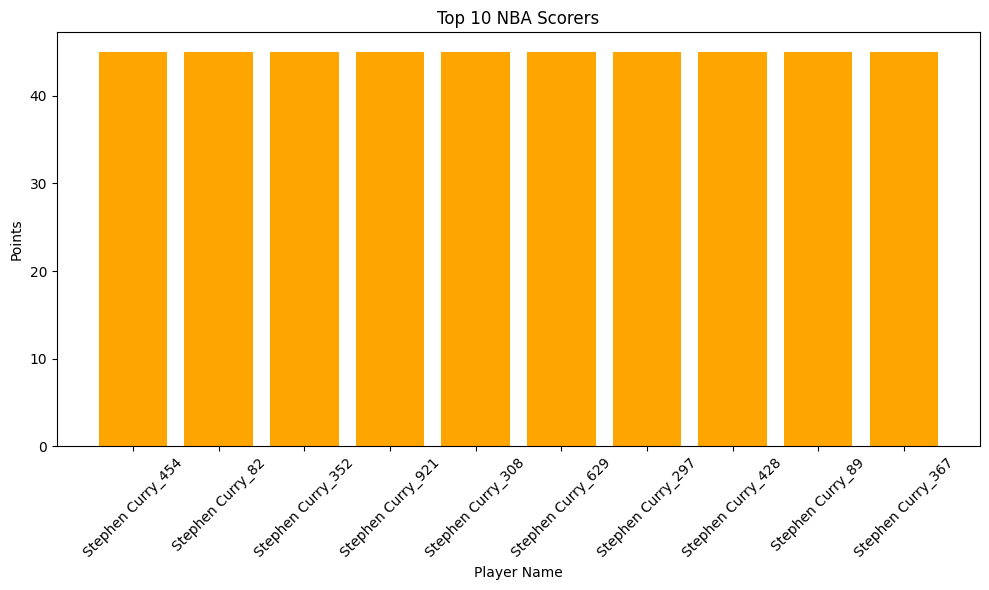

In [513]:
# basic initial visualization

top_scorers = df.sort_values(by='points', ascending=False).head(10)


plt.figure(figsize=(10, 6))
plt.bar(top_scorers['player_name'], top_scorers['points'], color='orange')
plt.xlabel('Player Name')
plt.ylabel('Points')
plt.title('Top 10 NBA Scorers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



       Team Name  Total Points
0           Suns          1993
1           Heat          1870
2        Thunder          1743
3        Celtics          1690
4       Warriors          1639
5          Spurs          1630
6         Knicks          1614
7      Cavaliers          1595
8          Bucks          1576
9       Clippers          1567
10     Grizzlies          1545
11      Pelicans          1532
12       Nuggets          1477
13         Bulls          1416
14     Mavericks          1414
15        Lakers          1408
16          Jazz          1378
17       Raptors          1357
18         76ers          1349
19         Hawks          1267
20  Timberwolves            35


<Axes: title={'center': 'Total Points by Team'}, xlabel='Team Name'>

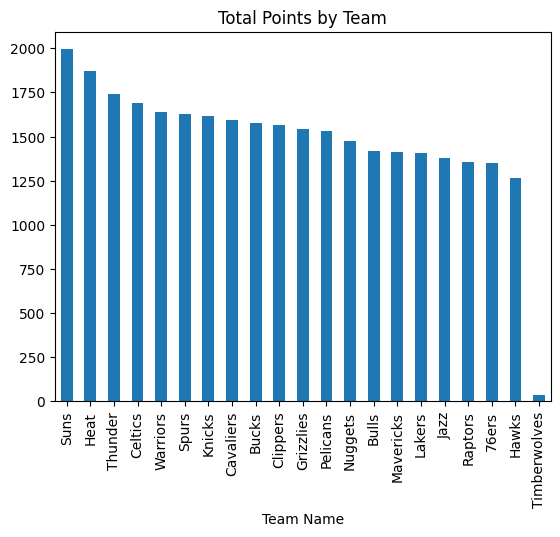

In [514]:
# visualization for total points per team


query = '''
  SELECT team_name, SUM(points) AS total_points
    FROM nba_stats
    GROUP BY team_name
    ORDER BY total_points DESC;
'''
cursor.execute(query)
results = cursor.fetchall()

# convert
df = pd.DataFrame(results, columns=['Team Name', 'Total Points'])


print(df)

df.plot(x='Team Name', y='Total Points', kind='bar', legend=False, title='Total Points by Team')


In [515]:
# interactive data visualization

query = '''
    SELECT team_name,
           ROUND(AVG(points), 2) AS avg_points,
           ROUND(AVG(assists), 2) AS avg_assists,
           ROUND(AVG(rebounds), 2) AS avg_rebounds
    FROM nba_stats
    GROUP BY team_name
    ORDER BY avg_points DESC
'''
df = pd.read_sql_query(query, conn)

# create interactive bar chart
fig = px.bar(
    df,
    x='team_name',
    y=['avg_points', 'avg_assists', 'avg_rebounds'],
    barmode='group',
    title="Average Performance Metrics by Team",
    labels={'team_name': "Team Name", 'value': "Average Metrics"},
    text_auto=True
)

# customizing layout
fig.update_layout(
    xaxis_title="Team Name",
    yaxis_title="Average Performance Metrics",
    legend_title="Metric",
    template="plotly_dark"  # this is optional: can toggle between light or dark theme
)

fig.show()


Mathematical analysis of the data reveals that the average points for the teams fall within a narrow range of 32.04 to 28.16, indicating relatively consistent performance across teams. The Timberwolves, however, deviate significantly from this norm, with an average of 17.5 points, which is 10.66 points lower than the next closest team. In terms of assists, the Timberwolves' average of 12 assists is notably higher than the next highest team, the Nuggets, with 8.11 assists, and the Thunder, with 8.05 assists, showing a clear outperformance in this metric.

Incorporating these findings, we observe that while the Timberwolves' low points output (17.5) positions them as an outlier, their high assist average (12) signals an intriguing strength in team play, further emphasized by their 3.89-point lead over the Nuggets in assists. This contrast suggests that while the Timberwolves may struggle offensively in terms of scoring, they compensate with strong ball movement and playmaking ability.

In the future, I'll emphasize more variability between statistics generated for different teams, rather than having one team (the Timberwolves) be a stark outlier

In [516]:
# updated function to include 'year' column
# went back and changed rows from 1 mil to 100,000


def generate_historical_data(num_records=100000):

    teams = ["Lakers", "Warriors", "Suns", "Bucks", "Celtics", "Mavericks", "Nuggets", "Grizzlies", "Heat", "Clippers"]

    # new synthetic data
    data = []
    for _ in range(num_records):
        player_name = f"Player_{random.randint(1, num_records)}"  # random names
        team_name = random.choice(teams)
        points = random.randint(0, 50)   # points
        assists = random.randint(0, 15)  # assists
        rebounds = random.randint(0, 20)  # rebounds
        year = random.randint(1980, 2024)  # years between 1980 2024
        data.append((player_name, team_name, points, assists, rebounds, year))
    return data


In [517]:
# count total rows in table

cursor.execute('SELECT COUNT(*) FROM nba_stats')
total_rows = cursor.fetchone()[0]
print(f"Total rows in the database: {total_rows}")

# query sample of the data

cursor.execute('SELECT * FROM nba_stats LIMIT 250')
sample_rows = cursor.fetchall()
for row in sample_rows:
    print(row)


Total rows in the database: 1032
(1, 'LeBron James', 'Lakers', 35, 8, 7, 2023, 38, 21, 'SF', 'Multiple injuries, including ankle and knee')
(2, 'LeBron James', 'Lakers', 35, 8, 7, 0, None, None, None, None)
(3, 'Stephen Curry', 'Warriors', 40, 10, 5, 0, None, None, None, None)
(4, 'Kevin Durant', 'Suns', 25, 6, 9, 0, None, None, None, None)
(5, 'Giannis Antetokounmpo', 'Bucks', 30, 5, 11, 0, None, None, None, None)
(6, 'Jayson Tatum', 'Celtics', 34, 4, 8, 0, None, None, None, None)
(7, 'Luka Doncic', 'Mavericks', 36, 9, 7, 0, None, None, None, None)
(8, 'Nikola Jokic', 'Nuggets', 28, 8, 14, 0, None, None, None, None)
(9, 'Ja Morant', 'Grizzlies', 32, 10, 6, 0, None, None, None, None)
(10, 'Jimmy Butler', 'Heat', 27, 5, 7, 0, None, None, None, None)
(11, 'Kawhi Leonard', 'Clippers', 26, 6, 5, 0, None, None, None, None)
(12, 'Pat Connaughton', 'Bucks', 17, 5, 3, 0, None, None, None, None)
(13, 'Anthony Davis', 'Lakers', 31, 3, 12, 0, None, None, None, None)
(14, 'Damian Lillard', 'Bucks'

Here we can see that the database is configured correctly. Players have been duplicated exponentially and assigned individual keys to serve as unique identifiers. My plan is to run advanced analytics with some machine learning frameworks. First I have to add more variables to create a more cohesive dataframe:

Age: Player's age at the time of the season.

Experience: Number of years in the league.

Position: Player's primary position (PG, SG, SF, PF, C).

Injury History: Indicator of past injuries and their impact on performance.

With these new columns added, now the database is more cohesive. I was planning to build a prediction model based on these 100,000 datapoints and see if this augmented historical data i created is able to provide any interesting randomized insights.

Augmenting and then processing and trying to print this much information used:

RAM: 3.87 GB/12.67 GB
Disk: 32.47 GB/107.72 GB

On the Python 3 Google Compute Engine backend


I need to go back and create less data as this completely crashed the colab file. If I subscribed to the service this would be more likely to run...  I'll try to optimize the size so I don't use all my available compute on this subscription plan


Now I will regenerate a more realistic database size that won't crash the cloud. I went back and updated to 100,000 rows




*   With the database functioning as expected, I can now apply machine learning,
starting with XGBoost. This symbolizes the downstream stakeholder as a machine learning engineer/data scientist who is using the database I generated and modeled to perform hypothesis testing and build recommendation systems etc.


*   To optimize the model's performance, I’ll begin by conducting hyperparameter tuning, as the initial version of the model was suboptimal. Once tuned, I’ll integrate the optimized parameters back into the algorithm for improved results.



In [518]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px
import plotly.graph_objects as go


dtrain = xgb.DMatrix(X_train, label=y_train)  # prepare data for XGBoost
dtest = xgb.DMatrix(X_test, label=y_test)


 # define parameters for the XGBoost model

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 5,
    'colsample_bytree': 0.5,
    'eval_metric': 'rmse'
}



evals = [(dtrain, 'train'), (dtest, 'eval')]  # train the model with early stopping
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=False
)


y_pred = bst.predict(dtest)


# evaluation metrics

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Optimized RMSE: {rmse}')
print(f'Optimized R-squared: {r2}')


# visualizing predicted versus actual values

pred_actual_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

fig_pred_actual = px.scatter(
    pred_actual_df,
    x='Actual',
    y='Predicted',
    title='Predicted vs Actual Points',
    labels={'Actual': 'Actual Points', 'Predicted': 'Predicted Points'},
    template='plotly_dark',
    trendline="ols"  # adds a trendline for clarity
)
fig_pred_actual.update_traces(marker=dict(size=8, color='red'))
fig_pred_actual.show()

# visualizing feature importance

feature_importances = bst.get_score(importance_type='weight')
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
feature_df = pd.DataFrame(sorted_importances, columns=['Feature', 'Importance'])

fig_feature_importance = px.bar(
    feature_df,
    x='Feature',
    y='Importance',
    title='Feature Importance (Interactive)',
    labels={'Importance': 'Importance Score', 'Feature': 'Feature'},
    template='plotly_dark'
)
fig_feature_importance.show()


Optimized RMSE: 2.117680959874783
Optimized R-squared: 0.24093252420425415


Programming a random forest algorithm to compare actual versus predicted assists

available columns in the dataframe: Index(['team_name', 'avg_points', 'avg_assists', 'avg_rebounds'], dtype='object')
all required columns are present
rmse: 0.28077826311876797
r-squared: -0.029411274417529887


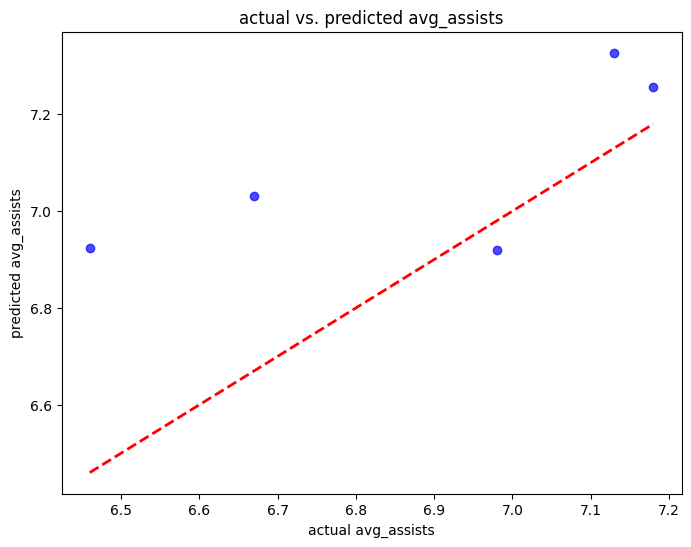

In [526]:
# check columns in the dataframe
print("available columns in the dataframe:", df.columns)

# ensure required columns are present
required_columns = ['avg_points', 'avg_rebounds', 'avg_assists']
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    print(f"missing columns: {missing_columns}")
else:
    print("all required columns are present")

# normalize column names
df.columns = df.columns.str.strip().str.lower()

# define features and target
X = df[['avg_points', 'avg_rebounds']]  # using avg_points and avg_rebounds as features
y = df['avg_assists']  # using avg_assists as the target

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize and train random forest
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# make predictions
y_pred = rf_model.predict(X_test)

# calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# print results
print(f'rmse: {rmse}')
print(f'r-squared: {r2}')

# scatter plot: actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('actual avg_assists')
plt.ylabel('predicted avg_assists')
plt.title('actual vs. predicted avg_assists')
plt.show()




*   Blue dots close to the red dashed line indicate that the model predicted the avg_assists value accurately for those instances.
*   Dots further from the red dashed line indicate less accurate predictions.



RMSE of 0.281 is a moderate error, but it's not enough to indicate a highly accurate model.


R-squared of -0.029 indicates that the model is performing poorly and may not be the right choice for this dataset, or there may be issues with the features (such as a weak relationship between the predictors and the target). The model is struggling to explain the variability in the target variable (avg_assists), and a more suitable model or feature engineering might be needed.This is expected as I threw this algorithm randomly (no pun intended) at the dataframe, so it is a solution looking for a problem. May come back and update this with a more robust ML algorithm in time.


Overall, I am happy with this result so far as I explored the full birth of the data lifecycle from requirements gathering to data generation and modeling to downstream use cases for end user stakeholders. I am eager to eventually continue refining the model through iterative improvements and deeper analysis.